In [1]:
import itertools
from collections import defaultdict

import ipdb  # noqa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import trange
from utils import lighten_color
from models import FADeepFullNet, NnConstructor
from utils import (XORDataset, errorfill, model2condition)

eps = 1e-13

seed = 12
torch.manual_seed(seed)
np.random.seed(seed)


In [13]:
def train_models(
    base_model,
    other_models,
    n_epochs,
    loss_func,
    device,
    learning_rate,
    momentum,
    train_data_loader,
    metric_func,
    test_data_loader=None,
    batch_interval=3,
):

    base_model.to(device=device)
    optimizer = torch.optim.Adam(
        base_model.parameters(),
        lr=learning_rate,
        # momentum=momentum,
    )

    base_model_cond = model2condition(base_model)
    print(f"base model condition is {base_model_cond}")

    epoch_loss = []
    grads_epoch = []

    epoch_metric = []
    epoch_hiddens = []
    epoch_labels = []

    pbar = trange(n_epochs)
    for epoch in pbar:
        grads_list = defaultdict(lambda: [])
        loss_list = defaultdict(lambda: [])
        metric_list = defaultdict(lambda: [])
        hidden_list = defaultdict(lambda: [])
        label_list = defaultdict(lambda: [])

        base_model.train()
        optimizer.zero_grad()

        eta = 1e-3
        for batch_idx, (data, target) in enumerate(train_data_loader):
            base_model_cond = model2condition(base_model)

            target = target.to(device)

            output, info = base_model(
                data.to(device) + eta * torch.randn(data.shape).to(device),
                retain_act_grad=True,
            )

            hidden_list[base_model_cond].append(
                info[-2].data.clone().unsqueeze(0).cpu().numpy())
            label_list[base_model_cond].append(
                target.data.clone().unsqueeze(0).cpu().numpy())
            loss = loss_func(output[:, 0], target)

            metric = metric_func(output, target)

            loss.backward()
            grads = base_model.get_grad()
            grads_list[base_model_cond].append(grads['decoder'])

            optimizer.step()
            loss_list[base_model_cond].append(loss.item())
            metric_list[base_model_cond].append(metric.item())

            # compare with other models.
            for other_model in other_models:
                other_model_cond = model2condition(other_model)
                for name, param in other_model.named_parameters():
                    assert name in other_model.state_dict().keys()
                    param.data = other_model.state_dict()[name].data.detach(
                    ).clone()

                other_model.zero_grad()
                other_output, other_info = other_model(data.to(device))
                other_loss = loss_func(other_output[:, 0], target)
                other_loss.backward()

                grads_list[other_model_cond].append(
                    other_model.get_grad()['decoder'])

                loss_list[other_model_cond].append(other_loss.item())
                metric_list[other_model_cond].append(
                    metric_func(other_output, target).item())

            if batch_idx % batch_interval == 0:
                pbar.set_description(
                    f"Loss={np.mean(loss_list[base_model_cond]):2.4f}, Metric={np.mean(metric_list[base_model_cond]):2.2f}"
                )



        epoch_loss.append(loss_list)
        epoch_metric.append(metric_list)
        grads_epoch.append(grads_list)

        epoch_hiddens.append(hidden_list)
        epoch_labels.append(label_list)

    return epoch_loss, epoch_metric, grads_epoch, epoch_hiddens, epoch_labels



In [14]:
device = "cpu"
dim_x = 2
dim_y = 1
n_hidden = "2"
batch_size = 1
res_xor = []
train_loader = torch.utils.data.DataLoader(
    XORDataset(),
    batch_size=batch_size,
    shuffle=False,
)
dw2_on = True
turn_on_dw2s = (dw2_on, )
feedback_options = ["BP", "FA"]
base_condition = (dw2_on, "FA")
compare_condition = (dw2_on, "BP")

base_model_w_o_s = []
n_repeats = 5

for r_ in range(n_repeats):
    other_models4comparison = []
    conditions = itertools.product(turn_on_dw2s, feedback_options)
    for condition in conditions:
        turn_on_dw2, feedback_option = condition

        n_epochs = 1000
        loss_func = torch.nn.MSELoss()

        # learning_rate = 1e-3 # good for FA
        learning_rate = 1e-4
        momentum = 0  # None

        if condition == base_condition:
            base_model = FADeepFullNet(
                dim_x,
                dim_y,
                d_hiddens=n_hidden,
                feedback_option=feedback_option,
                dw_decoder_on=turn_on_dw2,
                output_act_f=NnConstructor.construct_fixpoint(),
                fa_output_bias=False,
            )
            base_model_w_o_s.append(
                base_model.decoder.weight.data.detach().numpy())
        else:
            other_models4comparison.append(
                FADeepFullNet(
                    dim_x,
                    dim_y,
                    d_hiddens=n_hidden,
                    feedback_option=feedback_option,
                    dw_decoder_on=turn_on_dw2,
                    output_act_f=NnConstructor.construct_fixpoint(),
                    fa_output_bias=False,
                ))

    def _get_acc(output, target):
        """If output >=0.5, we see it as output 1, otherwise 0.
        """
        output_data = output.data.detach()
        return ((output_data >= 0)[:, 0] == (target >= 0)).float().mean()

    epoch_loss, epoch_metric, grads_epoch, epoch_hiddens, epoch_labels = train_models(
        base_model,
        other_models4comparison,
        n_epochs,
        loss_func,
        device,
        learning_rate,
        momentum,
        train_loader,
        _get_acc,
    )
    res_xor.append(
        (epoch_loss, epoch_metric, grads_epoch, epoch_hiddens, epoch_labels))

grads_epoch_BPs = []
grads_epoch_FAs = []
angle_grads_epoch_FABPs = []
base_loss_epochs = []
base_metric_epochs = []
base_hidden_epochs = []
base_label_epochs = []

for r_idx in range(n_repeats):

    angle_grads_epoch_FABP = []
    epoch_loss_single, epoch_metric_single, grads_epoch_single, epoch_hiddens_single, epoch_labels_single = res_xor[
        r_idx]

    base_loss_epochs.append(
        [np.mean(loss[base_condition]) for loss in epoch_loss_single])
    base_metric_epochs.append(
        [np.mean(metric[base_condition]) for metric in epoch_metric_single])

    base_hidden_epochs.append(
        np.concatenate(
            [
                epoch_hidden for epoch_hiddens in epoch_hiddens_single
                for epoch_hidden in epoch_hiddens[base_condition]
            ],
            axis=0,
        ))

    base_label_epochs.append(
        np.concatenate(
            [
                epoch_label for epoch_labels in epoch_labels_single
                for epoch_label in epoch_labels[base_condition]
            ],
            axis=0,
        ))

    for grads_e in grads_epoch_single:
        degrees = []
        for grad_BP, grad_FA in zip(grads_e[compare_condition],
                                    grads_e[base_condition]):
            norm_product = eps + np.sqrt(np.sum(grad_BP**2)) * np.sqrt(
                np.sum(grad_FA**2))
            radian = grad_BP.dot(grad_FA) / norm_product
            radian = np.clip(radian, -1, 1)
            degree = 180 * np.arccos(radian) / np.pi
            degrees.append(degree)

        angle_grads_epoch_FABP.append(np.mean(degrees))

    angle_grads_epoch_FABP = np.array(angle_grads_epoch_FABP)
    angle_grads_epoch_FABPs.append(angle_grads_epoch_FABP)

angle_grads_epoch_FABPs = np.array(angle_grads_epoch_FABPs)

base_loss_epochs = np.array(base_loss_epochs)
base_metric_epochs = np.array(base_metric_epochs)

# dim: repeats, epochs, batch, neuron
base_hidden_epochs = np.array(base_hidden_epochs)

# dim: repeats, epochs, batch
base_label_epochs = np.array(base_label_epochs)


figsize = (4, 4)
fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)

epochs = np.arange(base_loss_epochs.shape[1]) + 1

errorfill(
    epochs,
    base_loss_epochs.mean(axis=0),
    base_loss_epochs.std(axis=0),
    ax=axes[0],
    label=base_condition[1],
)

errorfill(
    epochs,
    base_metric_epochs.mean(axis=0),
    base_metric_epochs.std(axis=0),
    ax=axes[1],
    label=base_condition[1],
)

axes[0].legend()
axes[0].set_ylabel("Loss")

axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")
plt.suptitle(base_condition)
plt.tight_layout()
plt.show()

base model condition is (True, 'FA')


Loss=1.1137, Metric=0.75: 100%|██████████| 1000/1000 [00:07<00:00, 130.31it/s]


base model condition is (True, 'FA')


Loss=0.0663, Metric=1.00:  57%|█████▋    | 568/1000 [00:04<00:03, 136.29it/s]


KeyboardInterrupt: 

In [9]:
g_base_condition = np.array([g[base_condition] for g in grads_epoch_single])
g_compare_condition = np.array([g[compare_condition] for g in grads_epoch_single])
g_compare_condition.shape

(10000, 1, 2)

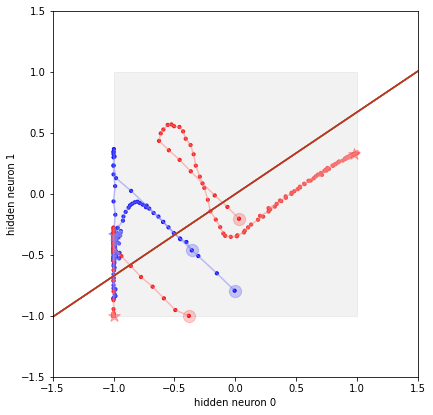

In [4]:
r_idx = 4

w_o_0, w_o_1 = base_model_w_o_s[r_idx][0]


def sep_line(x):
    return -(w_o_0 / w_o_1) * x


# each epoch contains all possible labels
labels = sorted(list(set(base_label_epochs[r_idx][0])))
cmap = matplotlib.cm.get_cmap(name='bwr', lut=len(labels))

fig, ax = plt.subplots(figsize=[6, 6])
vm = max(abs(base_hidden_epochs[r_idx].min()),
         abs(base_hidden_epochs[r_idx].max()))
vmin = -(vm + 0.5)
vmax = vm + 0.5
for within_epoch_idx in range(base_hidden_epochs[r_idx].shape[1]):
    single_h_evolution = base_hidden_epochs[r_idx][:, within_epoch_idx, :]
    label4single_input = base_label_epochs[r_idx][:, within_epoch_idx]
    assert np.all(label4single_input == label4single_input[0])

    time_indices = np.linspace(0, len(single_h_evolution) - 1, 100).astype(int)

    cur_label = label4single_input[0]

    relative_indices = 1 - time_indices / time_indices.max()
    relative_indices = relative_indices * 0.6
    colors = [
        lighten_color(cmap(cur_label), amount=0.4 + relative_idx)
        for relative_idx in relative_indices
    ]
    ax.plot(single_h_evolution[time_indices, 0],
            single_h_evolution[time_indices, 1],
            c=lighten_color(cmap(cur_label), amount=0.5),
            alpha=0.5)

    ax.scatter(
        single_h_evolution[time_indices, 0],
        single_h_evolution[time_indices, 1],
        c=colors,
        s=10,
        # alpha=0.2,
    )

    size = 150
    # plot the init points
    ax.scatter(single_h_evolution[0, 0],
               single_h_evolution[0, 1],
               marker="o",
               s=size,
               alpha=0.2,
               color=cmap(cur_label))

    # plot the end points
    ax.scatter(single_h_evolution[-1, 0],
               single_h_evolution[-1, 1],
               marker="*",
               s=size,
               alpha=0.3,
               color=cmap(cur_label))

    # plot decision boundary
    h_i0s = np.linspace(vmin, vmax, 50)
    h_i1s = sep_line(h_i0s)
    ax.plot(h_i0s, h_i1s)

ax.set_aspect('equal')
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)

ax.fill_between(
    [-1, 1],
    -1,
    1,
    color="grey",
    alpha=0.1,
)

ax.set_xlabel("hidden neuron 0")
ax.set_ylabel("hidden neuron 1")
plt.tight_layout()
plt.show()

In [6]:
base_hidden_epochs[r_idx].min()

-1.1999809

In [7]:
print(base_model_w_o_s)

[array([[ 0.475564  , -0.89352417]], dtype=float32), array([[ 0.475564  , -0.89352417]], dtype=float32), array([[ 0.475564  , -0.89352417]], dtype=float32), array([[ 0.475564  , -0.89352417]], dtype=float32), array([[ 0.475564  , -0.89352417]], dtype=float32)]


In [8]:
x = torch.rand(10, 4)